This notebook shows how to use LLM-Geo, you can uncomment a study case (preferred Case 1 and Case 3) to get the spatial analysis results without any human intervention. 

Please check the [webpage of LLM-Geo](https://github.com/gladcolor/LLM-Geo) for more detail!


#  Install package

Make sure you are using the latest version of `openai` and `geopandas`.

In [1]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install openai
# ! pip install openai --upgrade
# ! conda update  --channel conda-forge geopandas  


# Import package

In [2]:
import os
import sys
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
import rasterio
from pyvis.network import Network
from openai import OpenAI
from IPython.display import display, HTML, Code
from IPython.display import clear_output

# Define Solution class
Please run the following cell to define the functions

In [3]:
%load_ext autoreload
%autoreload 2

import LLM_Geo_Constants as constants
import helper

from LLM_Geo_kernel import Solution

sys.path.append(os.path.abspath("Modules"))    
import Modules.data_eye as data_eye

# Demonstration Cases

## Input task and data desciption

In [4]:
isReview = True

In [5]:

# Case 1: population living near hazardous wastes

# task_name ='Resident_at_risk_counting'
# TASK = r"""1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
# 2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please draw all polygons, not only the highlighted ones. The map size is 15*10 inches.
# """

## data location with column information
# DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
#                   "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip. The tract ID column is 'GEOID', data types is integer.",
#                   "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID', data types is integer."
#                  ]

# data location without column information
# DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
#                   "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip.",
#                   "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv."
#                  ]
 

# # Case 3: COVID-19 death rate in US
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a choropleth map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red. Set figure size to 15*10 inches.  
# '''

# data location with column information
# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'; map projection is EPSG:4269",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]

# data location without column information
# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip.",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. "
#                  ]

# # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

## data location with column information
# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'Longitude' column, latitude in 'Latitude' column.",          
# ]

# data location without column information
# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv.",          
# ]

# # Case 5: school walkability
task_name ='School walkability'
TASK = r'''You need to assess the walkability for all schools in the Colubmia city. Requirements:
1) Using 1 km buffer zone as the study area for each school, compuate each school's walkability scores, which is the ratio of the sidewalk length to the road length in the buffer zone.
2) Draw a map for each school, using the school name and the walkability score as the map title, while showing the sidewalks and the buffer zone on a OpenStreetMap basemap.
'''

# data location with column information
DATA_LOCATIONS = [
r"Columbia school (points): https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_schools.gpkg.",
r"Columbia road network (polyline): https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_road.gpkg.",          
r"Columbia sidewalk network (polyline): https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_sidewalks.gpkg." 
]

##  Case 6: Trunk diameter error
# task_name = "Trunk diameter error"
# TASK = """You need to compute the location error between the estimated tree trunk and the ground truth: 
# 1) for each ground truth location, find out its nearest estimated location within 3 meters. 
# 2) compute the RMSE for ground truth trunks that have the associated estimated location."
# """

# DATA_LOCATIONS = [
# r"Estimated trunk location: D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Data\Street_view_image\trunk_location_estimated_EPSG6569.shp.", 
# r"Trunk ground truth: D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Data\Street_view_image\trunk_location_ground_truth_EPSG6569.shp."
# ]

##  Case 7: Population difference
# task_name = "Population difference"
# TASK = """Make a thematic map, show the difference between the resident population data and the LandScan gridded nighttime population for the Census tracts in North Carolina. 
# """
# DATA_LOCATIONS = [
# r"North Carolina Census tract boundaris: D:/OneDrive_PSU/OneDrive - The Pennsylvania State University/Data/LandScan/North_Carolina_tracts.shp", 
# r"USA residential population at block group level: D:/OneDrive_PSU/OneDrive - The Pennsylvania State University/Data/LandScan/Residential_population.csv",
# r"USA LandScan nighttime population at block group level: D:/OneDrive_PSU/OneDrive - The Pennsylvania State University/Data/LandScan/landscan-usa-2021-night.csv"
# ]


##  Case 8: Store site selection
# task_name = "Store site selection"
# TASK = """Propose a new Walmart store location, which has similar distances to the existing four locations, while near the roads within 300 meters.
# """

# DATA_LOCATIONS = [
# r"Existing Walmart locations: D:/OneDrive_PSU/OneDrive - The Pennsylvania State University/Data/Walmart_site/Walmart_4_site_EPSG32111.shp", 
# r"Road network: D:/OneDrive_PSU/OneDrive - The Pennsylvania State University/Data/Walmart_site/Motorway_EPSG32111.shp",
# ]

##  Case 9: random points
# task_name = "Random points"
# TASK = """You have a point layer, and need to do: inside the extent of this layer, generate as much as possible random points that with a minimum distance of 100 m, while with a minimum distance of 30 m to the given points. 
# """

# DATA_LOCATIONS = [
# r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Data\Street_tree\Richland_downtown_street_view_image_location.shp",
# ]

##  Case 10: Air quality sensor
# task_name = "Air_quality_sensor"
# TASK = """The loaded data is the real-time readings of a PM2.5 sensors on 2023-06-29, 341 readings in total. 
# You need to create an HTML report containing: 
# 1) a map showing the location of air quality sensor with  a basemap. 
# 2) a plot showing real-time readings of the sensor. 
# 3) a table showing all the readings.
# """

# DATA_LOCATIONS = [
# r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Data\Air_quality\1289807.csv",
# ]

# # Case 2: France_mobility_changes_2020  (NOTE: invalidated due to API shutdown)
# task_name ='France_mobility_changes_2020'
# TASK = r'''
# 1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range (color scheme: coolwarm). The base of the change rate is January 2020. 
# 2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
# '''

# DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
#                   "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
#                   "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
#                   "REST API url with parameters for daily human mobility data access:" + \
#                   "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
#                   "The response is in CSV format. There are three columns in the response: " + \
#                   "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country;" + \
#                   "codes for France administrative regions start with 'FRA'. Use the total intra_movement of the month as the montly mobility.",
#                  ]


save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)




In [6]:
# create graph
# model = r'gpt-4o'
# model = r'gpt-4o-2024-08-06'
# model = r'o1-preview'  # Not ready yet. 2024-12-26/
# model = r'o1'  # Not ready yet. 2025-02-05/
model = r'o3-mini'  # Slow, may need to reasoning before generating tokens. Tested on 2025-02-09/


# model = r'o1-mini'   #  Error code: 400 - {'error': {'message': "Unsupported value: 'messages[0].role' does not support 'system' with this model.", 'type': 'invalid_request_error', 'param': 'messages[0].role', 'code': 'unsupported_value'}}
# no system prompt,  no temperature setting, no response format (json-object)

In [7]:
# file_path = r'https://github.com/gladcolor/spatial_data/raw/refs/heads/master/Everest_DEM.tif'
# file_path = r'https://github.com/gladcolor/spatial_data/raw/refs/heads/master/Everest_DOM.tif'
# file_path = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM_Geo\QGIS_plugin\sentinel2.tif"
# file_path = r"C:\Users\A\Downloads\Sentinel_downloaded\L1C_T31TBF_A043377_20231012T105229_2023-10-12\L1C_T31TBF_A043377_20231012T105229_B09.jp2"

## Get data overview (column names, data types, and map projection)

In [8]:
attributes_json, DATA_LOCATIONS = data_eye.add_data_overview_to_data_location(task=TASK, data_location_list=DATA_LOCATIONS, model=model)
print("DATA_LOCATIONS with data overviews:")
print(DATA_LOCATIONS)

DATA_LOCATIONS with data overviews:
["Columbia school (points): https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_schools.gpkg.Columbia school (points): https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_schools.gpkg. Data overview: {'column names and data types': 'column names, data types, and sample values (column_name: data_type, sample value |):[amenity: object, school| ele: object, nan| gnis:feature_id: object, nan| name: object, nan| id: int64, 1076093983| type: object, way| wikidata: object, nan| operator: object, nan| addr:city: object, nan| addr:country: float64, nan| addr:housenumber: object, nan| addr:postcode: object, nan| addr:state: object, nan| addr:street: object, nan| contact:facebook: float64, nan| contact:twitter: float64, nan| contact:youtube: float64, nan| fax: float64, nan| grades: float64, nan| isced:level: float64, nan| operator:type: float64, nan| operator:wikidata: float64, nan| operato

In [9]:
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and programmer good at Python. You have worked on Geographic information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. You know well how to set up workflows for spatial analysis tasks. You have significant experence on graph theory, application, and implementation. You are also experienced on generating map using Matplotlib and GeoPandas.
 

Your task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 You need to assess the walkability for all schools in the Colubmia city. Requirements:
1) Using 1 km buffer zone as the study area for each school, compuate each school's walkability scores, which is the ratio of the sidewalk length to the road length in the buffer zone.
2) Draw a map for each school, using the school name and the walkability score as the map title, while 

## Get graph code from GPT API

In [10]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx
G = nx.DiGraph()

# 1. Load Columbia schools dataset
G.add_node("schools_data_url", node_type="data", data_path="https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_schools.gpkg", description="Columbia schools dataset URL")
G.add_node("load_schools", node_type="operation", data_path="", description="Load Columbia schools dataset into a GeoDataFrame")
G.add_edge("schools_data_url", "load_schools")
G.add_node("schools_gdf", node_type="data", data_path="", description="Columbia schools GeoDataFrame")
G.add_edge("load_schools", "schools_gdf")

# 2. Load Columbia road network dataset
G.add_node("roads_data_url", node_type="data", data_path="https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_road.gpkg", description="Columbia road network dataset URL")
G.add_node("load_roads", node_type="operation", data_path="", description="Load Columbia road network dataset into a GeoDataFrame")
G.add_edge("roads_data_url", "load_roads")
G.add_node("roads_gdf", node_type="data", data_path="", description="Columbia road network GeoDataFrame")
G.add_edge("load_roads", "roads_gdf")

# 3. Load Columbia sidewalk network dataset
G.add_node("sidewalks_data_url", node_type="data", data_path="https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_sidewalks.gpkg", description="Columbia sidewalk network dataset URL")
G.add_node("load_sidewalks", node_type="operation", data_path="", description="Load Columbia sidewalk network dataset into a GeoDataFrame")
G.add_edge("sidewalks_data_url", "load_sidewalks")
G.add_node("sidewalks_gdf", node_type="data", data_path="", description="Columbia sidewalk network GeoDataFrame")
G.add_edge("load_sidewalks", "sidewalks_gdf")

# 4. Generate 1 km buffer zone for each school
G.add_node("buffer_schools", node_type="operation", data_path="", description="Generate 1 km buffer for each school from schools GeoDataFrame")
G.add_edge("schools_gdf", "buffer_schools")
G.add_node("schools_buffer_gdf", node_type="data", data_path="", description="Columbia schools GeoDataFrame with 1 km buffer zone")
G.add_edge("buffer_schools", "schools_buffer_gdf")

# 5. Clip road and sidewalk networks within school buffers
G.add_node("clip_networks", node_type="operation", data_path="", description="Clip roads and sidewalks using the school buffer zones")
G.add_edge("schools_buffer_gdf", "clip_networks")
G.add_edge("roads_gdf", "clip_networks")
G.add_edge("sidewalks_gdf", "clip_networks")
G.add_node("networks_in_buffer", node_type="data", data_path="", description="Road and sidewalk networks clipped to school buffer zones")
G.add_edge("clip_networks", "networks_in_buffer")

# 6. Compute walkability scores (sidewalk length / road length) for each school
G.add_node("compute_walkability", node_type="operation", data_path="", description="Calculate walkability score for each school using sidewalk and road lengths in buffers")
G.add_edge("networks_in_buffer", "compute_walkability")
G.add_node("walkability_scores", node_type="data", data_path="", description="GeoDataFrame with walkability scores for each school")
G.add_edge("compute_walkability", "walkability_scores")

# 7. Generate maps for each school using an OSM basemap
G.add_node("plot_maps", node_type="operation", data_path="", description="Create maps for each school showing the buffer zone and sidewalks on an OSM basemap with title (school name and walkability score)")
G.add_edge("schools_buffer_gdf", "plot_maps")
G.add_edge("walkability_scores", "plot_maps")
G.add_edge("sidewalks_gdf", "plot_maps")
G.add_node("final_school_maps", node_type="data", data_path="", description="Final output maps for each Columbia school with walkability scores")
G.add_edge("plot_maps", "final_school_maps")

# Save the network to a GraphML file (this saving process is executed outside the workflow steps)
nx.write_graphml(G, r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Researc

## Execute code to generate the solution graph

In [11]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

 

D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM_Geo\Python_code\School walkability.html


## Generate prompts and code for operations (functions)

In [12]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

def load_schools(schools_data_url='https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_schools.gpkg'):
    """
    Load Columbia schools dataset into a GeoDataFrame.
    Parameters:
        schools_data_url (str): URL of the Columbia schools dataset.
    Returns:
        schools_gdf (GeoDataFrame): Loaded GeoDataFrame of Columbia schools.
    """
    import geopandas as gpd

    # Load the dataset using GeoPandas
    schools_gdf = gpd.read_file(schools_data_url)
    
    # Ensure the GeoDataFrame has a valid CRS; convert to EPSG:4326 if needed.
    if schools_gdf.crs is None or schools_gdf.crs.to_string() != 'EPSG:4326':
        schools_gdf = schools_gdf.to_crs(epsg=4326)
    
    # Drop records with missing geometry and essential attribute 'name'
    if 'name' in schools_gdf.columns:
        schools_gdf = schools_gdf.dropna(subset=['name'])
    schools_gdf = schools_gdf[schools_gdf.geometry.notnull()]
    
    return schools_gdf
import geopandas as gpd

def load_roads(roads_data_url='https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_road.gpkg'):
    """
    Load Columbia road network dataset into a GeoDataFrame.
    
    Parameters:
    roads_data_url (str): URL to the Columbia road network dataset (GeoPackage).
    
    Returns:
    GeoDataFrame: GeoDataFrame containing the Columbia road network data.
    """
    # Load the road network dataset using GeoPandas
    roads_gdf = gpd.read_file(roads_data_url)
    
    # Remove records with missing geometry to ensure data integrity for spatial operations
    roads_gdf = roads_gdf.dropna(subset=['geometry'])
    
    return roads_gdf
def load_sidewalks(sidewalks_data_url='https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_sidewalks.gpkg'):
    """
    Load Columbia sidewalk network dataset into a GeoDataFrame
    """
    import geopandas as gpd
    # Load the sidewalk dataset using GeoPandas read_file method
    sidewalks_gdf = gpd.read_file(sidewalks_data_url)
    
    # Drop records with missing 'id' values which are essential for further processing
    sidewalks_gdf = sidewalks_gdf.dropna(subset=['id'])
    
    return sidewalks_gdf
def buffer_schools(schools_gdf=schools_gdf):
    """
    Generate 1 km buffer for each school from schools GeoDataFrame.
    Parameters:
        schools_gdf (GeoDataFrame): Columbia schools GeoDataFrame with point geometries in EPSG:4326.
    Returns:
        schools_buffer_gdf (GeoDataFrame): Columbia schools GeoDataFrame where the geometry is replaced by a 1 km buffer zone.
    """
    import geopandas as gpd

    # Ensure there are no records with missing geometry
    schools_gdf = schools_gdf[schools_gdf.geometry.notnull()]

    # Convert to a projected CRS that uses meters (EPSG:3857) for accurate buffering
    schools_proj = schools_gdf.to_crs(epsg=3857)

    # Generate a 1 km (1000 meter) buffer for each school
    schools_proj['geometry'] = schools_proj.geometry.buffer(1000)

    # Convert the buffered geometries back to EPSG:4326 to match other spatial layers
    schools_buffer_gdf = schools_proj.to_crs(epsg=4326)

    return schools_buffer_gdf
import geopandas as gpd
import pandas as pd

def clip_networks(roads_gdf=roads_gdf, sidewalks_gdf=sidewalks_gdf, schools_buffer_gdf=schools_buffer_gdf):
    """
    Clip roads and sidewalks using the school buffer zones.
    
    Parameters:
        roads_gdf (GeoDataFrame): Columbia road network GeoDataFrame.
        sidewalks_gdf (GeoDataFrame): Columbia sidewalk network GeoDataFrame.
        schools_buffer_gdf (GeoDataFrame): Columbia schools GeoDataFrame with 1 km buffer zones.
        
    Returns:
        networks_in_buffer (dict): A dictionary with two GeoDataFrames:
            'roads' - road segments clipped to school buffer zones with an added 'school_name' attribute.
            'sidewalks' - sidewalk segments clipped to school buffer zones with an added 'school_name' attribute.
 

## Generate prompts and code for assembly program

In [13]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D

def load_schools(schools_data_url='https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_schools.gpkg'):
    """
    Load Columbia schools dataset into a GeoDataFrame.
    Parameters:
        schools_data_url (str): URL of the Columbia schools dataset.
    Returns:
        schools_gdf (GeoDataFrame): Loaded GeoDataFrame of Columbia schools.
    """
    schools_gdf = gpd.read_file(schools_data_url)
    
    # Ensure the GeoDataFrame has a valid CRS; convert to EPSG:4326 if needed.
    if schools_gdf.crs is None or schools_gdf.crs.to_string() != 'EPSG:4326':
        schools_gdf = schools_gdf.to_crs(epsg=4326)
    
    # Drop records with missing geometry and essential attribute 'name'
    if 'name' in schools_gdf.columns:
        schools_gdf = schools_gdf.dropna(subset=['name'])
    schools_gdf = schools_gdf[schools_gdf.geometry.notnull()]
    
    return schools_gdf

def load_roads(roads_data_url='https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_road.gpkg'):
    """
    Load Columbia road network dataset into a GeoDataFrame.
    
    Parameters:
        roads_data_url (str): URL to the Columbia road network dataset.
    
    Returns:
        GeoDataFrame: Road network data.
    """
    roads_gdf = gpd.read_file(roads_data_url)
    roads_gdf = roads_gdf.dropna(subset=['geometry'])
    return roads_gdf

def load_sidewalks(sidewalks_data_url='https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_sidewalks.gpkg'):
    """
    Load Columbia sidewalk network dataset into a GeoDataFrame.
    """
    sidewalks_gdf = gpd.read_file(sidewalks_data_url)
    sidewalks_gdf = sidewalks_gdf.dropna(subset=['id'])
    return sidewalks_gdf

def buffer_schools(schools_gdf):
    """
    Generate 1 km buffer for each school from schools GeoDataFrame.
    
    Parameters:
        schools_gdf (GeoDataFrame): Columbia schools GeoDataFrame with point geometries in EPSG:4326.
    Returns:
        schools_buffer_gdf (GeoDataFrame): Schools with geometry replaced by a 1 km buffer zone.
    """
    schools_gdf = schools_gdf[schools_gdf.geometry.notnull()]
    # Convert to projected CRS EPSG:3857 for buffering in meters
    schools_proj = schools_gdf.to_crs(epsg=3857)
    schools_proj['geometry'] = schools_proj.geometry.buffer(1000)
    schools_buffer_gdf = schools_proj.to_crs(epsg=4326)
    return schools_buffer_gdf

def clip_networks(roads_gdf, sidewalks_gdf, schools_buffer_gdf):
    """
    Clip roads and sidewalks using the school buffer zones.
    
    Parameters:
        roads_gdf (GeoDataFrame): Columbia road network GeoDataFrame.
        sidewalks_gdf (GeoDataFrame): Columbia sidewalk network GeoDataFrame.
        schools_buffer_gdf (GeoDataFrame): Schools with 1 km buffer zones.
        
    Returns:
        networks_in_buffer (dict): Dictionary with two GeoDataFrames:
            'roads' and 'sidewalks' clipped to school buffer zones, with an added 'school_name' attribute.
    """
    # Ensure all layers are in the same CRS
    if roads_gdf.crs != schools_buffer_gdf.crs:
        roads_gdf = roads_gdf.to_crs(schools_buffer_gdf.crs)
    if sidewalks_gdf.crs != schools_buffer_gdf.crs:
        sidewalks_gdf = sidewalks_gdf.to_crs(schools_buffer_gdf.crs)
    
    roads_gdf = roads_gdf[roads_gdf.geometry.notnull()]
    sidewalks_gdf = sidewalks_gdf[sidewalks_gdf.geometry.notnull()]
    
    roads_list = []
    sidewalks_list = []
    
    # For each school, clip the networks and tag with the school name
    for idx, school in schools_buffer_gdf.iterrows():
        school_id = school.get('name', idx)
        buffer_geom = school.geometry
        
        clipped_roads = gpd.clip(roads_gdf, buffer_geom)
        if not clipped_roads.empty:
            clipped_roads = clipped_roads.copy()
          

## Execute assembly code



-------------- Running code (trial # 1/10) --------------


Error_info_str: 
Traceback (most recent call last):
  File "Complete program", line 55, in <module>
    def buffer_schools(schools_gdf=schools_gdf):
NameError: name 'schools_gdf' is not defined

Sending error information to LLM for debugging...
Below is the corrected and complete code. In the original code the functions buffer_schools, clip_networks, and plot_maps used default parameters (e.g., schools_gdf=schools_gdf) referring to variables that had not yet been defined. I removed these default values so that the functions must be called with the proper arguments. I also removed duplicate definitions so that each function is defined only once. Finally, I ensured that all spatial layers (GeoDataFrames) are reprojected consistently when needed and that the code meets the requirements for loading zipped ESRI data from a URL via gpd.read_file().

Below is the final corrected code:

----------------------------------------------

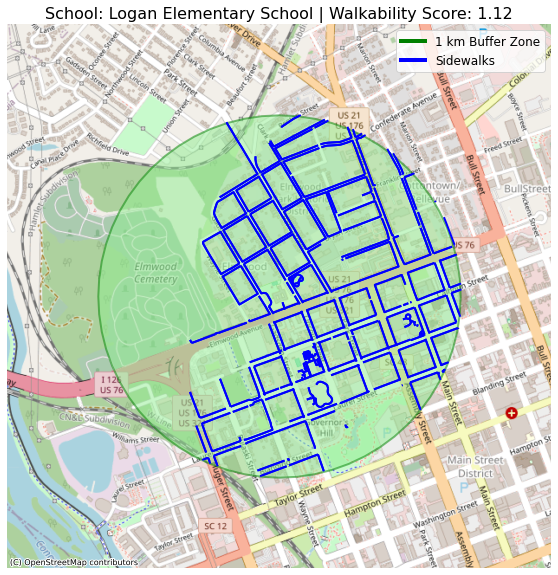

In [14]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)